In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'../..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

hyspeclab_dir = os.path.join(project_dir, 'HySpecLab')
if hyspeclab_dir not in sys.path:
    sys.path.append(hyspeclab_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)    

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import config

## Dataset

In [2]:
from HySpecLab.dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get(dataframe=True)

### Normalization (Z-Score)

In [3]:
x_normalized = (x.values - x.mean().values) / x.std().values
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)

## Feature Reduction

Due to a computational limitation, it is now only possible to apply the selection of features by Bayesian optimization up to 64 features. This step is used in order to reduce the number of features based on Tree-based feature importance score.

In [4]:
from HySpecLab.feature_selection import InterbandRedundacyMutualInformationSelector

selector = InterbandRedundacyMutualInformationSelector(threshold=10, undersampling=256, gamma=.5)
selector.fit(x_normalized.values, y.values.flatten())

/home/abian/Workspace/Thesis/IUMA/HySpecLab/notebooks/optimization/../../modules/IPDL/IPDL/InformationTheory.py:21: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  eigv = torch.symeig(A)[0].abs()


InterbandRedundacyMutualInformationSelector(threshold=10)

In [5]:
print('Features Selected: {}'.format(np.where(selector.mask_)[0]))
X_transform = selector.transform(x_normalized.values)

Features Selected: [  0   1   3   4   5   6   7   8  10  12  20  30  33  47  64  72  88  95
 103 107 108 112 113 114 115]


## Dataset balancing

In [6]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Randomly selecting a subset of data for the targeted classes:
# rus = RandomUnderSampler(random_state=123)
# x, y = rus.fit_resample(x, y)

# # Let positive samples be the samples belonging to the targeted class to be under-sampled. 
# # Negative sample refers to the samples from the minority class.
# # Select the positive samples for which the average distance to the N closest samples of the negative 
# # class is the smallest
sampling_strategy = {0: 2048, 1: 2048}
nm = NearMiss(sampling_strategy=sampling_strategy, version=3)
X_resampled, y_resampled = nm.fit_resample(X_transform, y)

# from undersample import HyperSpectralUnderSampler

# # ....
# undersampler = HyperSpectralUnderSampler(n_clusters=40, samples_per_cluster=15, random_state=123)
# x, y = undersampler.fit_resample(x,y)

# Proposed metric
Based on Lasso approach, a metric have been proposed to penalize activation of the features.

## Accuracy penalized by number of features


$\begin{align}
    Acc_{penalized} = Acc - \frac{2 \alpha Acc}{1 + \lambda / \lambda_{max}}
\end{align}$

where $Acc$ is the accuracy, $\lambda_{max}$ the number of features of the original samples, $\lambda$ the number of features selectioned and $\alpha$ is a paramter of regularization.

In [7]:
def accuracy_penalized(acc, n_features_selected, n_features, alpha=.5):
    penalization = (2*alpha*acc / (1 + (n_features/n_features_selected)))
    return acc - penalization

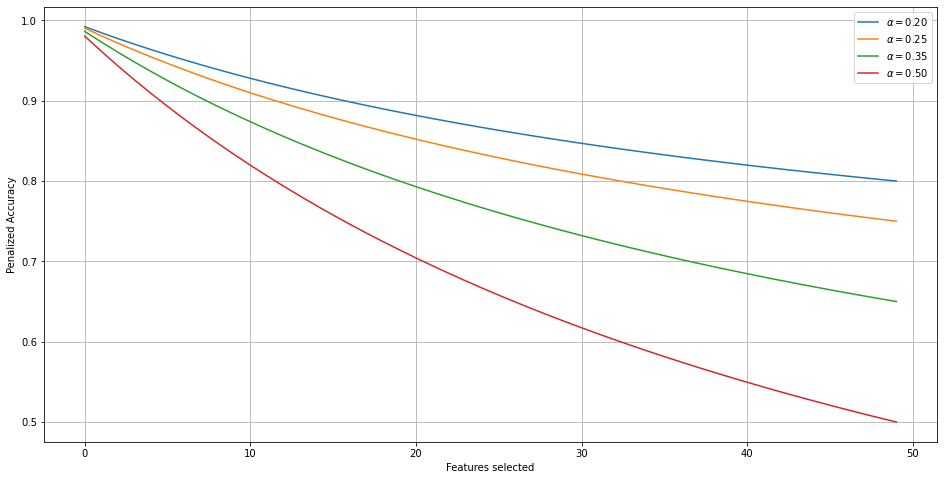

In [8]:
acc = 1
n_features = 50
n_features_selected = np.arange(1, 51, 1, dtype=np.uint)

fig, ax = plt.subplots(figsize=(16, 8))
proposed_alpha = [.2, .25, .35, .5]
for alpha_value in proposed_alpha:
    acc_penalized = accuracy_penalized(acc, n_features_selected, n_features, alpha=alpha_value)
    ax.plot(acc_penalized, label=r"$\alpha = {%.2f}$" % alpha_value)

ax.set_xlabel('Features selected')
ax.set_ylabel('Penalized Accuracy')

plt.grid(True)
plt.legend()
plt.show()

# Parameters optimization

In [13]:
from skopt.space import Integer, Real, Categorical

n_features = X_resampled.shape[1]

search_space = list()
# search_space.append(Integer(1, 2**(n_features)-1, 'log-uniform', name='transform__selected_features', dtype=np.uint64))
search_space.append(Integer(1, 2**(n_features)-1, 'log-uniform', name='transform__selected_features'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='svc__C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='svc__kernel'))
search_space.append(Integer(1, 5, name='svc__degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='svc__gamma'))

In [14]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from skopt.utils import use_named_args

from HySpecLab.feature_selection.aux import FeatureSelection

# define the function used to evaluate a given configuration
@use_named_args(search_space) # https://scikit-optimize.github.io/stable/modules/generated/skopt.utils.use_named_args.html
def evaluate_model(**params):
	# configure the model with specific hyperparameters
	model = Pipeline([("transform", FeatureSelection(n_features=n_features)), ('svc', SVC())])
	model.set_params(**params)
	# define test harness
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X_resampled, y_resampled.values.flatten(), cv=cv, n_jobs=1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = np.mean(result)
	
	# Accuracy penalization based on number of features selected
	if model['transform'].selected_features:		
		feature_idx = model['transform'].getIndex()
		estimate = accuracy_penalized(estimate, feature_idx.sum(), model['transform'].n_features, alpha=.2)

	# convert from a maximizing score to a minimizing score
	return 1.0 - estimate


# Bayesian Optimization

In [15]:
from datetime import datetime

# Experiment ID
exp_id = f'E{datetime.now().timestamp()}'.split('.')[0]

In [16]:
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver, TimerCallback, VerboseCallback

from HySpecLab.utils import BoardLog
# This does not work with a CheckpointSaver at the same time
tb_log = BoardLog('log/{}'.format(exp_id), space_name=['Features', 'C', 'kernel', 'degree', 'gamma'])

checkpoint_saver = CheckpointSaver("./checkpoints/{}.pkl".format(exp_id), compress=9) # keyword arguments will be passed to `skopt.dump`

result = gp_minimize(evaluate_model, search_space, callback=[checkpoint_saver], random_state=123)

ValueError: Found input variables with inconsistent numbers of samples: [4096, 10638]

## Continue search from checkpoint

In [ ]:
from skopt import load

###############################
# Important!                  #
# Introduce the Experiment ID #
###############################
exp_id = '' 

checkpoint_path = 'checkpoints/{}.pkl'.format(exp_id)  

res = load(checkpoint_path) 
x0 = res.x_iters
y0 = res.func_vals

checkpoint_saver = CheckpointSaver(checkpoint_path, compress=9)

result = gp_minimize(
            evaluate_model, 
            search_space,
            x0=x0,              # already examined values for x
            y0=y0,              # observed values for x0
            callback=[checkpoint_saver], 
            random_state=123 )